In [1]:
import sys
sys.path.append('/home/kotobiam/hida_project/')

In [2]:
from typing import Dict, Any, List
from ase.io import read, write

from attribution_gnn1.QM9_SpecData import QM9_SpecData
from utils.broadening import spectrum
from utils.visualisation import plot_prediction

import shutil
from pathlib import Path
import glob
import os.path as osp 
import re
import pandas as pd
import numpy as np
import copy

from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem.rdchem import HybridizationType
from rdkit.Chem import rdDetermineBonds
from rdkit.Chem import rdMolTransforms

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

from pylab import rc, rcParams
rc('text', usetex=False)
rc('axes', linewidth=2)
rc('font', weight='normal')

params = {'legend.fontsize': 10,
          'figure.figsize': (6, 4),
         'axes.labelsize': 25,
         'axes.titlesize': 25,
         'xtick.labelsize':25,
         'ytick.labelsize':25,
         'figure.dpi' : 200}
rcParams.update(params)
from matplotlib.ticker import FormatStrFormatter

from sklearn.preprocessing import MinMaxScaler

import torch
from torch_scatter import scatter
from torch_geometric.data import Data, Dataset

# prepare dataset and extract the random molecules indexes 

In [7]:
gdata = '/home/kotobiam/data_qm9/qm9_spec_random50_0-8eV_bl_pd.pt'
qm9_dist_rand = QM9_SpecData(root=gdata,
             raw_dir='/home/kotobiam/data_qm9/raw/',
             spectra=[])

In [8]:
qm9_dist_rand

QM9_SpecData(50)

In [9]:
all_idx = []
for i in range(50):
    all_idx.append(qm9_dist_rand[i].idx)

# test distortion

In [22]:
mol = read("./structure_10526.xyz")

In [10]:
mol.positions

array([[ 0.70147787,  0.20159298, -1.09520071],
       [-0.05052827,  0.01806443,  0.08916836],
       [ 0.61090179, -0.70933171,  1.09436924],
       [ 1.73374468,  0.02942293,  1.79572796],
       [ 1.26135633,  1.31893464,  2.45976603],
       [ 2.39184637,  1.9300396 ,  3.06613444],
       [-0.3034598 , -1.59923   ,  1.88319791],
       [ 0.68636034, -2.20502789,  0.90666657],
       [ 1.04687293, -0.75656998, -1.50819539],
       [ 0.03847327,  0.68273195, -1.81840895],
       [ 1.57663322,  0.84788632, -0.94034126],
       [ 2.17716013, -0.62196195,  2.55638776],
       [ 2.53869196,  0.27270958,  1.09192133],
       [ 0.80343131,  1.97411431,  1.70474021],
       [ 0.48335509,  1.0861038 ,  3.20401126],
       [ 2.10717406,  2.75950513,  3.46018143],
       [-0.12199874, -1.71446066,  2.94629719],
       [-1.34756436, -1.5990619 ,  1.5932472 ],
       [ 0.28121584, -2.60747429, -0.01499867],
       [ 1.54585661, -2.73924648,  1.29703052]])

In [71]:
from ase.visualize import view
view(mol, viewer='x3d')

In [23]:
mol.rattle(stdev=0.04)

In [12]:
mol.positions

array([[ 0.70644501,  0.20021034, -1.08872383],
       [-0.03529797,  0.0157229 ,  0.08682699],
       [ 0.62669392, -0.70165736,  1.08967449],
       [ 1.73917028,  0.02478876,  1.79107066],
       [ 1.26377595,  1.29980184,  2.44251685],
       [ 2.38622349,  1.91991128,  3.06927692],
       [-0.31254004, -1.61335303,  1.8978544 ],
       [ 0.68410257, -2.20435261,  0.89241909],
       [ 1.0414291 , -0.75546076, -1.51970533],
       [ 0.04223025,  0.67672557, -1.82132589],
       [ 1.57061615,  0.8664091 , -0.94047623],
       [ 2.16658302, -0.61373651,  2.54417932],
       [ 2.54078059,  0.25311288,  1.07863947],
       [ 0.80539993,  1.98149897,  1.70645389],
       [ 0.48219861,  1.08309276,  3.18922604],
       [ 2.09997562,  2.75489874,  3.47075266],
       [-0.11856256, -1.73209106,  2.94953803],
       [-1.35141518, -1.60583112,  1.59936396],
       [ 0.29152583, -2.59816149, -0.02339085],
       [ 1.54276449, -2.73593385,  1.30678597]])

In [77]:
view(mol, viewer='x3d')

In [24]:
write("./structure_10526_dist.xyz", images=mol, format="xyz")

# batch distortion

In [7]:
path = '/beegfs/desy/user/kotobiam/DFT_calculations/nexafs_dataset_prep/QM9_dataset_nexafs/distortion_nexafs_cals_pd/xyz_coords/'
xyz_files = glob.glob(osp.join(path, '*.xyz'))

In [8]:
path_t_distorted = '/beegfs/desy/user/kotobiam/DFT_calculations/nexafs_dataset_prep/QM9_dataset_nexafs/distortion_nexafs_cals_pd/xyz_coords/distorted_mols_0.02'
for file in xyz_files:
    mol_to_distort = read(file)
    mol_to_distort.rattle(stdev=0.02)
    write(osp.join(path_t_distorted, f"{osp.basename(file)}"), 
          images=mol_to_distort, format="xyz")

# convert xyz file to smiles 

In [25]:
raw_mol = Chem.MolFromXYZFile('structure_10526_dist.xyz')
mol = Chem.Mol(raw_mol)
rdDetermineBonds.DetermineBonds(mol,charge=0)

In [92]:
raw_mol

NameError: name 'raw_mol' is not defined

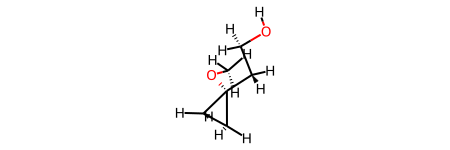

In [26]:
mol

# Visualise XAS plots for distorted molecules

In [10]:
path = Path('/beegfs/desy/user/kotobiam/DFT_calculations/nexafs_dataset_prep/QM9_dataset_nexafs/distortion_nexafs_cals_pd')

In [11]:
def plot_xas_distortion(path: Path, 
                        struc_idx: int,
                        save: bool = False):
    files = glob.glob(osp.join(path, 
                               f"distorted_mols_*/structure_{struc_idx}/*dat"))
    fig, ax = plt.subplots()
    
    for file in files:
        label = f"distortion: {file.split('/')[-3].split('_')[-1]}"
        
        df_dat = pd.read_csv(file, delim_whitespace=True, 
                             header=None, usecols=[0, 1])
        df_dat.columns = ['energy', 'osc']
        
        df_dat['osc'] = MinMaxScaler().fit_transform(df_dat['osc'].values.reshape(-1, 1))
        df_dat.plot(x='energy', y='osc', label=label, ax=ax)
    
    ax.legend()
    ax.set_yticklabels([])
    ax.set_xlabel('Energies (eV)')
    ax.set_ylabel('Intensity (arb. units)')
    ax.tick_params(axis='x', which='major', direction='out', 
                bottom=True, width=2, length=5)

    if save:
        plt.savefig('./spectra.png', dpi=300, bbox_inches='tight') 

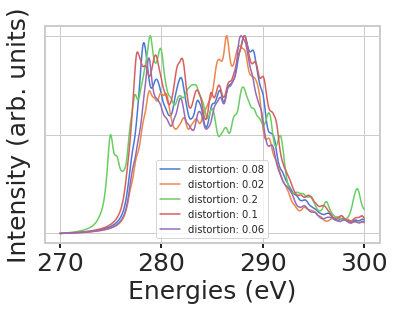

In [12]:
plot_xas_distortion(path, struc_idx=40)

# Predict XAS for distorted molecules 

In [13]:
path_xyz = Path('/beegfs/desy/user/kotobiam/DFT_calculations/nexafs_dataset_prep/',
                'QM9_dataset_nexafs/distortion_nexafs_cals_pd/xyz_coords/')

In [14]:
def make_smiles_dist(
    path: Path, 
    dist: float,
    orig_idx: List[int]
):
    files = files = sorted(glob.glob(osp.join(path_xyz, 
                               f"distorted_mols_{dist}/*mol")),
                key= lambda f : int(re.sub('\D', '', f)))
    dist_smiles = {}
    for file, idx in zip(files, orig_idx):
        dist_smiles[idx] = Chem.MolFromMolFile(file, removeHs=False) 
    df_dist_smiles = pd.DataFrame(dist_smiles, index=[0]).T.reset_index()
    df_dist_smiles.columns = ['id', 'distorted_smiles']
    return df_dist_smiles

In [85]:
df_dist_smiles = make_smiles_dist(path_xyz, dist=0.06, orig_idx=sorted(all_idx))

In [13]:
df_dist_smiles

,id,distorted_smiles
0,196,<rdkit.Chem.rdchem.Mol object at 0x2b2186db4040>
1,529,<rdkit.Chem.rdchem.Mol object at 0x2b2186db4200>
2,2010,<rdkit.Chem.rdchem.Mol object at 0x2b2186db4190>
3,2655,<rdkit.Chem.rdchem.Mol object at 0x2b2186db40b0>
4,3425,<rdkit.Chem.rdchem.Mol object at 0x2b2186cdec80>
5,3822,<rdkit.Chem.rdchem.Mol object at 0x2b2186df05f0>
6,4580,<rdkit.Chem.rdchem.Mol object at 0x2b2186df0660>
7,4953,<rdkit.Chem.rdchem.Mol object at 0x2b2186df06d0>
8,5039,<rdkit.Chem.rdchem.Mol object at 0x2b2186df0740>
9,6899,<rdkit.Chem.rdchem.Mol object at 0x2b2186df07b0>


In [32]:
## Create smiles
def make_smiles_dist(path: Path, dist: float):
    files = files = sorted(glob.glob(osp.join(path_xyz, 
                               f"distorted_mols_{dist}/*xyz")),
                key= lambda f : int(re.sub('\D', '', f)))
    dist_smiles = {}
    for file in files:  
        k = re.sub('\D', '',
                   osp.basename(file).split('.')[0])  
        raw_mol = Chem.MolFromXYZFile(file)
        mol = Chem.Mol(raw_mol)
        try:
            rdDetermineBonds.DetermineBonds(mol,charge=0, removeHs=False)
        except Exception as e:
            print(e)           
        dist_smiles[int(k)] = Chem.MolToSmiles(mol)
    df_dist_smiles = pd.DataFrame(dist_smiles, index=[0]).T.reset_index()
    df_dist_smiles.columns = ['id', 'distorted_smiles']
    return df_dist_smiles

In [41]:
df_dist_smiles = make_smiles_dist(path_xyz, dist=0.02)

Python argument types in
    rdkit.Chem.rdDetermineBonds.DetermineBonds(Mol)
did not match C++ signature:
    DetermineBonds(RDKit::ROMol {lvalue} mol, bool useHueckel=False, int charge=0, double covFactor=1.3, bool allowChargedFragments=True, bool embedChiral=True, bool useAtomMap=False)
Python argument types in
    rdkit.Chem.rdDetermineBonds.DetermineBonds(Mol)
did not match C++ signature:
    DetermineBonds(RDKit::ROMol {lvalue} mol, bool useHueckel=False, int charge=0, double covFactor=1.3, bool allowChargedFragments=True, bool embedChiral=True, bool useAtomMap=False)
Python argument types in
    rdkit.Chem.rdDetermineBonds.DetermineBonds(Mol)
did not match C++ signature:
    DetermineBonds(RDKit::ROMol {lvalue} mol, bool useHueckel=False, int charge=0, double covFactor=1.3, bool allowChargedFragments=True, bool embedChiral=True, bool useAtomMap=False)
Python argument types in
    rdkit.Chem.rdDetermineBonds.DetermineBonds(Mol)
did not match C++ signature:
    DetermineBonds(RDKit

In [35]:
PandasTools.AddMoleculeColumnToFrame(df_dist_smiles, 'distorted_smiles', 'id')
PandasTools.WriteSDF(df_dist_smiles, './distortion_0.02.sdf', molColName='id')

[15:27:46] WARNING: not removing hydrogen atom without neighbors
[15:27:46] WARNING: not removing hydrogen atom without neighbors
[15:27:46] WARNING: not removing hydrogen atom without neighbors
[15:27:46] WARNING: not removing hydrogen atom without neighbors
[15:27:46] WARNING: not removing hydrogen atom without neighbors
[15:27:46] WARNING: not removing hydrogen atom without neighbors
[15:27:46] WARNING: not removing hydrogen atom without neighbors
[15:27:46] WARNING: not removing hydrogen atom without neighbors
[15:27:46] WARNING: not removing hydrogen atom without neighbors
[15:27:46] WARNING: not removing hydrogen atom without neighbors
[15:27:46] WARNING: not removing hydrogen atom without neighbors
[15:27:46] WARNING: not removing hydrogen atom without neighbors
[15:27:46] WARNING: not removing hydrogen atom without neighbors
[15:27:46] WARNING: not removing hydrogen atom without neighbors
[15:27:46] WARNING: not removing hydrogen atom without neighbors
[15:27:46] WARNING: not r

In [36]:
suppl_distor = Chem.SDMolSupplier('./distortion_0.02.sdf', 
                           removeHs=False, sanitize=False)

In [41]:
# exchange of indexes to refer to original ones 
idx_exchange = {original_idx: changed_idx for original_idx, changed_idx \
                in zip(df_dist_smiles['id'].values, range(50))}

In [42]:
def data_distort_graph(path_to_spec: Path, 
                       distortion: float,
                       idx_exchange: Dict[int, int],
                       #suppl_distor: Chem.rdmolfiles.SDMolSupplier, 
                       smiles: pd.DataFrame):
    
    types = {'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4}
    bonds = {BT.SINGLE: 0, BT.DOUBLE: 1, BT.TRIPLE: 2, BT.AROMATIC: 3}
    
    data_list = []

    for mol, i in zip(smiles['distorted_smiles'], list(smiles['id'])):
        N = mol.GetNumAtoms()
        conf = mol.GetConformer()
        pos = conf.GetPositions()
        pos = torch.tensor(pos, dtype=torch.float)
    
        type_idx = []
        atomic_number = []
        aromatic = []
        sp = []
        sp2 = []
        sp3 = []
        num_hs = []

        for atom in mol.GetAtoms():
            type_idx.append(types[atom.GetSymbol()])
            atomic_number.append(atom.GetAtomicNum())
            aromatic.append(1 if atom.GetIsAromatic() else 0)
            hybridization = atom.GetHybridization()
            sp.append(1 if hybridization == HybridizationType.SP else 0)
            sp2.append(1 if hybridization == HybridizationType.SP2 else 0)
            sp3.append(1 if hybridization == HybridizationType.SP3 else 0)

        z = torch.tensor(atomic_number, dtype=torch.long)

        row, col, edge_type, bl = [], [], [], []
        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            row += [start, end]
            col += [end, start]
            edge_type += 2 * [bonds[bond.GetBondType()]]
            bl += 2 * [rdMolTransforms.GetBondLength(conf, 
                                                        bond.GetBeginAtomIdx(), 
                                                        bond.GetEndAtomIdx())]

        edge_index = torch.tensor([row, col], dtype=torch.long)
        edge_type = torch.tensor(edge_type, dtype=torch.long)
        edge_attr = torch.nn.functional.one_hot(
                  edge_type, num_classes=len(bonds)
                   ).to(torch.float)
        edge_length = torch.tensor(bl, dtype=torch.float)
        #edge_length = (edge_length - torch.mean(edge_length)) / torch.std(edge_length)
        edge_length = (edge_length - edge_length.min()) / (edge_length.max() - edge_length.min())

        perm = (edge_index[0] * N + edge_index[1]).argsort()
        edge_index = edge_index[:, perm]
        edge_type = edge_type[perm]
        edge_attr = edge_attr[perm]
        edge_length = edge_length[perm]
        
        #calculate pairwise distances
        idx_t, idx_s = edge_index[0], edge_index[1]
        V_ts = pos[:, None, :] - pos[None, :, :]
        D_ij = torch.sqrt(torch.sum(V_ts**2, dim=1))
        
        row, col = edge_index
        hs = (z == 1).to(torch.float)
        num_hs = scatter(hs[row], col, dim_size=N).tolist()

        x1 = torch.nn.functional.one_hot(
                  torch.tensor(type_idx), num_classes=len(types)
                )
        x2 = torch.tensor([atomic_number, aromatic, sp, sp2, sp3, num_hs],
                                dtype=torch.float).t().contiguous()

        x = torch.cat([x1.to(torch.float), x2, D_ij], dim=-1)

        data = Data(x=x, z=z, pos=pos, edge_index=edge_index,
                      edge_attr=torch.cat([edge_attr, edge_length.reshape(-1,1)], -1), idx=i)
        data_list.append(data)
    
    #add XAS spectra to graphs
    energies = torch.linspace(270, 300, 100)
    sigma=torch.tensor(0.8)
    for g in data_list:
        mol_idx = g.idx 
        changed_idx = idx_exchange[mol_idx]
        try:
            spec = np.loadtxt(
                osp.join(path_to_spec,
                         f"distorted_mols_{distortion}/structure_{changed_idx}/structure_{changed_idx}.out.abs.stk")
            )
            E = torch.tensor(spec[:, 0])
            osc = torch.tensor(spec[:, 1])
            g.spectrum = spectrum(E, osc, sigma, energies) 
        except Exception as e:
            print(e)
    return data_list

In [86]:
path_to_spec = Path('/beegfs/desy/user/kotobiam/DFT_calculations/nexafs_dataset_prep/QM9_dataset_nexafs/distortion_nexafs_cals_pd')
graph_data_dist = data_distort_graph(path_to_spec, 0.06, 
                                     idx_exchange, 
                                     df_dist_smiles.dropna())

/beegfs/desy/user/kotobiam/DFT_calculations/nexafs_dataset_prep/QM9_dataset_nexafs/distortion_nexafs_cals_pd/distorted_mols_0.06/structure_6/structure_6.out.abs.stk not found.


In [53]:
graph_data_dist

[Data(x=[10, 14], edge_index=[2, 20], edge_attr=[20, 5], pos=[10, 3], z=[10], idx=196, spectrum=[100]),
 Data(x=[14, 14], edge_index=[2, 26], edge_attr=[26, 5], pos=[14, 3], z=[14], idx=529, spectrum=[100]),
 Data(x=[14, 14], edge_index=[2, 30], edge_attr=[30, 5], pos=[14, 3], z=[14], idx=2010, spectrum=[100]),
 Data(x=[15, 14], edge_index=[2, 28], edge_attr=[28, 5], pos=[15, 3], z=[15], idx=2655, spectrum=[100]),
 Data(x=[13, 14], edge_index=[2, 28], edge_attr=[28, 5], pos=[13, 3], z=[13], idx=3425, spectrum=[100]),
 Data(x=[9, 14], edge_index=[2, 18], edge_attr=[18, 5], pos=[9, 3], z=[9], idx=3822, spectrum=[100]),
 Data(x=[16, 14], edge_index=[2, 32], edge_attr=[32, 5], pos=[16, 3], z=[16], idx=4580),
 Data(x=[11, 14], edge_index=[2, 22], edge_attr=[22, 5], pos=[11, 3], z=[11], idx=4953, spectrum=[100]),
 Data(x=[14, 14], edge_index=[2, 28], edge_attr=[28, 5], pos=[14, 3], z=[14], idx=5039, spectrum=[100]),
 Data(x=[20, 14], edge_index=[2, 40], edge_attr=[40, 5], pos=[20, 3], z=[20]

## make prediction with distorted graphs and visualise

In [19]:
from src.models import SpectraGNN, SpectraGAT, SpectraGraphNet

In [30]:
spectragraphnet = SpectraGraphNet(
                 node_dim = 14,
                 edge_dim = 5,
                 hidden_channels = 128,
                 out_channels = 200,
                 gat_hidd = 128,
                 gat_out = 100,
                 n_layers = 4,
                 n_targets = 100).to('cpu')

# loading the saved model 
path_to_model = osp.join('/home/kotobiam/data_qm9/trained_models/best_model', 
                         'spectragraphnet_50k_bl_pd.pt')

if osp.exists(path_to_model):
    spectragraphnet.load_state_dict(torch.load(path_to_model))
else:
    print('model is not loaded')

In [23]:
spectragraphnet

SpectraGraphNet(
  (graphnets): ModuleList(
    (0): GraphNetwork(
      (gatencoder): GATEncoder(
        (gats): ModuleList(
          (0): GATv2Conv(14, 128, heads=3)
          (1): ReLU(inplace=True)
          (2): GATv2Conv(384, 128, heads=3)
          (3): ReLU(inplace=True)
          (4): GATv2Conv(384, 128, heads=3)
          (5): ReLU(inplace=True)
          (6): GATv2Conv(384, 100, heads=1)
        )
      )
      (node_model): NodeModel(
        (mlp): Sequential(
          (0): Linear(in_features=124, out_features=128, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=128, out_features=200, bias=True)
          (3): ReLU(inplace=True)
          (4): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        )
      )
      (edge_model): EdgeModel(
        (mlp): Sequential(
          (0): Linear(in_features=505, out_features=128, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=128, out_features=200, bias=True)
 

In [23]:
def xas_dist(index: int,
             gdata_distorted: Any, 
             gdata_undistorted: Any,
             model: Any, 
             gnn_type: str,
             save_names: List[str],
             save_fig: bool = False,
             ):
     # graph data
    graph_distorted = copy.deepcopy(gdata_distorted[index])
    # find the corresponding undistored graph
    def return_idx(gdata_undistorted, wanted_graph):
        for i, graph in enumerate(gdata_undistorted):
            if graph.idx == wanted_graph.idx:
                return i
    undist_idx = return_idx(qm9_dist_rand, graph_distorted)
    graph_undist = copy.deepcopy(qm9_dist_rand[undist_idx])
    
    for g, fname in zip([graph_distorted, graph_undist],
                 save_names):
        model.to('cpu')
        model.eval()
        with torch.no_grad():
            if gnn_type == 'graphNet':
                # input only graph
                y_pred = model(g)
            else:
                y_pred = model(g.x,
                               g.edge_index,
                               g.batch)

        x_pred = np.linspace(270, 300, 100)
        y_pred = y_pred.numpy().flatten()
        y_true = g.spectrum 

        plot_prediction(x_pred, 
                    y_pred, 
                    y_true, 
                    normalise=True, 
                    add_peaks=False,
                    save=save_fig,
                    save_name=fname)

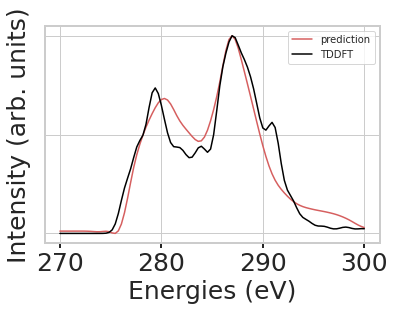

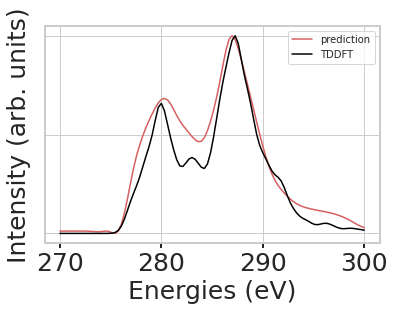

In [87]:
xas_dist(13,
         graph_data_dist,
         qm9_dist_rand,
         spectragraphnet,
         gnn_type='graphNet',
         save_names=['dist_vis', 'undist_vis'],
         save_fig=True)

In [81]:
graph_data_dist[13]

Data(x=[18, 14], edge_index=[2, 34], edge_attr=[34, 5], pos=[18, 3], z=[18], idx=12100, spectrum=[100])